# ONNX Conv Test

Test1: Domain change

Test2: Precision between 4 computations

In [1]:
import io
import numpy as np
import onnx
import onnxruntime
import matplotlib.pyplot as plt
import tenseal as ts
import torch

from onnx import helper
from onnx import numpy_helper
from onnx import TensorProto
from torch import nn
from torch.onnx import export as export_onnx

In [7]:
input_length = 28
OPSET_VERSION = 14

## Test 1

Domain change after convolution should be
`mult_domain(x,w).scale(n_channels * kernel_size ** 2)`, 

with `n_channels_in * kernel_size ** 2 = np.prod(w.shape[1:])`

**test strategy:**

conv-kernel with all 1s, image with all 1s => result image should contain everywhere `n_channels_in * kernel_size ** 2`

**Result:**

works

In [16]:
# 2D Conv with ones
n_inputs = input_length * input_length
n_channels_in = 2
n_channels_out = 4
kernel_size = 7
stride = 4
model = nn.Conv2d(n_channels_in, n_channels_out, kernel_size, stride)

# set conv weights and bias to 1s
w = torch.ones(model.weight.data.shape)
b = torch.zeros(model.bias.data.shape)
model.weight.data = w
model.bias.data = b

In [17]:
# all 1s input
ones = torch.ones([1, n_channels_in, input_length, input_length])

result = model(ones)

print(f"expected result: {np.prod(w.shape[1:])}\n")

print(result)

expected result: 98

tensor([[[[98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.]],

         [[98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.]],

         [[98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.]],

         [[98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
          [98., 98., 98., 98., 98., 98.],
       

## Test 2

Precision comparison
1. onnx cleartext ("onnxruntime")
2. torch.nn model cleartext ("pytorch")
3. matrix vector mult cleartext ("numpy")
4. encrypted matrix vector mult ("tenseal")

**Result:**

unfortunately only float precision - but otherwise computation is precise

In [5]:
# 2D Conv
n_inputs = input_length * input_length
n_channels_in = 2
n_channels_out = 4
kernel_size = 2
stride = 2
model = nn.Conv2d(n_channels_in, n_channels_out, kernel_size, stride)

export_onnx(
    model,
    torch.empty([1, n_channels_in, input_length, input_length]),
    "./graphs/conv.onnx",
    opset_version=OPSET_VERSION,
)

In [7]:
model_path = "./graphs/conv.onnx"

model = onnx.load(model_path)

In [12]:
# input for all tests
np.random.seed(27)
x = np.asarray(np.random.random([1,n_channels_in,input_length,input_length]), np.float32)

w = numpy_helper.to_array(model.graph.initializer[0])
b = numpy_helper.to_array(model.graph.initializer[1])

result_dict = {}

In [53]:
# 1 - direct onnxruntime

session = onnxruntime.InferenceSession(model_path)
y = session.run(None, {model.graph.input[0].name: x})

result_dict["onnxruntime"] = np.array(y).ravel()

In [54]:
# 2 - nn.Conv2d
conv_layer = nn.Conv2d(1,4,7,stride=3, dtype=torch.double)
conv_layer.weight.data = torch.tensor(w)
conv_layer.bias.data = torch.tensor(b)

x2 = torch.tensor(x)
y2 = conv_layer(x2)

result_dict["pytorch"] = y2.detach().numpy().ravel()

In [13]:
## compute M_conv and bias_conv

n_channels_in = 2
n_channels_out = 4
in_shape = [input_length, input_length]
n_dims = len(in_shape)

atts = {}
for a in model.graph.node[0].attribute:
    if a.name == "group":
        atts[a.name] = a.i
    else:
        atts[a.name] = a.ints
        
out_shape = [
    int(
        float(
            in_shape[i]
            + sum(atts["pads"][i::n_dims])
            - atts["dilations"][i] * (atts["kernel_shape"][i] - 1)
            - 1
        )
        / float(atts["strides"][i])
        + 1
    )
    for i in range(n_dims)
]      

X = helper.make_tensor_value_info("X", TensorProto.FLOAT, [None, n_channels_in] + in_shape)
Y = helper.make_tensor_value_info("Y", TensorProto.FLOAT, [None, n_channels_out] + out_shape)

# Create Conv node
node_def = helper.make_node(
    "Conv",  # node name
    ["X", "W"],  # inputs (B is optional and dropped as it has to be 0)
    ["Y"],  # outputs
    dilations=atts["dilations"],
    group=atts["group"],
    kernel_shape=atts["kernel_shape"],
    pads=atts["pads"],
    strides=atts["strides"],
)

weight_init = onnx.helper.make_tensor(
    name="W",
    data_type=onnx.mapping.NP_TYPE_TO_TENSOR_TYPE[w.dtype],
    dims=w.shape,
    vals=w.flatten(),
)

# Create the graph (GraphProto)
graph_def = helper.make_graph([node_def], "conv-model", [X], [Y], initializer=[weight_init])

model_def = helper.make_model(graph_def)
model_def.opset_import[0].version = OPSET_VERSION
onnx.checker.check_model(model_def)
buffer = io.BytesIO()
onnx.save(model_def, buffer)
session = onnxruntime.InferenceSession(buffer.getvalue())

full_in_shape = [1, n_channels_in, input_length, input_length]

# run convolution with identity matrix as input to get convolution matrix
eye = np.eye(
    np.prod(full_in_shape[1:]), dtype=w.dtype
).reshape(
    [np.prod(full_in_shape[1:]), n_channels_in]
    + in_shape
)

conv_matrix = np.array(session.run(None, {"X": eye})).reshape(
    np.prod(full_in_shape[1:]),
    n_channels_out * np.prod(out_shape),
)

bias_conv = np.repeat(b, np.prod(out_shape))

x3 = x.reshape(1,-1)
y3 = x3 @ conv_matrix + bias_conv

result_dict["numpy"] = y3.ravel()

In [56]:
## 3 - clear matrix vector multiplication

x3 = x.reshape(1,-1)
y3 = x3 @ M_conv + bias_conv

result_dict["numpy"] = y3.ravel()

In [10]:
## 4 - encrypted matrix vector multiplication
bits_scale = 44
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, bits_scale, 60]
)
context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

x4 = x.ravel()
x_enc = ts.ckks_vector(context, x4)

y4 = x_enc @ M_conv + bias_conv

result_dict["tenseal"] = np.array(y4.decrypt())

In [11]:
for k,v in result_dict.items():
    print(k, v.shape)

{'onnxruntime': array([-6.19999021e-02,  7.19095618e-02,  1.60606325e-01,  2.39548683e-02,
         1.03775069e-01,  7.42430240e-03,  2.67285019e-01, -6.34066314e-02,
         1.15010411e-01,  4.01613832e-01,  3.90729785e-01, -9.36917961e-03,
         1.14430718e-01, -2.64870644e-01,  1.76768988e-01,  1.56156600e-01,
         1.20641649e-01,  3.56182829e-02,  5.64947017e-02,  1.11960545e-02,
        -2.15437874e-01, -6.20188117e-02, -1.50331900e-01,  3.73155549e-02,
         7.93774650e-02,  6.45632297e-02,  6.18801527e-02,  4.81329560e-02,
        -1.86416551e-01, -2.34366670e-01, -1.83173344e-01,  1.96521550e-01,
         2.06097588e-02,  2.02745810e-01,  1.76288933e-03,  1.22627832e-01,
        -3.05508524e-02, -1.89647958e-01, -6.27228022e-02, -3.67063284e-02,
        -5.58713228e-02, -8.50900114e-02, -1.28039151e-01, -1.31410807e-01,
         1.28064215e-01,  5.13806939e-02, -2.38108337e-02, -6.32456690e-03,
        -2.59547234e-01, -2.06626341e-01,  1.62713647e-01,  3.18889201e-0

max error: 1.6391277313232422e-07


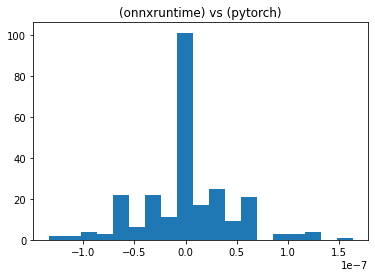

max error: 1.7881393432617188e-07


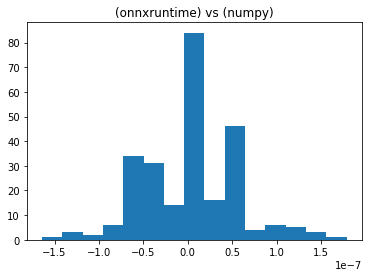

max error: 1.4413941151758536e-07


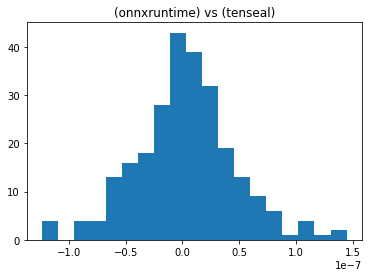

max error: 2.8312206268310547e-07


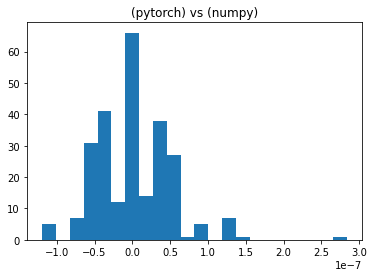

max error: 1.43619300119191e-07


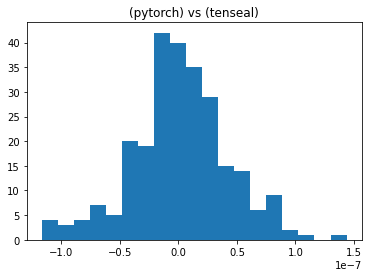

max error: 2.0147693607919237e-07


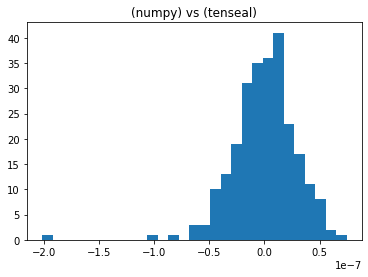

In [12]:
for i,(k,v) in enumerate(result_dict.items()):
    for i2,(k2,v2) in enumerate(result_dict.items()):
        if i2 > i:
            delta = v - v2
            max_err = max(abs(delta))

            print(f"max error: {max_err}")
            plt.hist(delta, "auto")
            plt.title(f"({k}) vs ({k2})")
            plt.show()